# Possession Predictor
By: Pranay Singla

## Import libraries

In [1]:
import tensorflow as tf
print(tf.__version__)

2.3.1


In [2]:
import os
import csv
import random
import time

In [3]:
import pandas as pd
import numpy as np

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model, Sequential

## Exploratory Data Analysis


In [7]:
labels_df = pd.read_csv('labels.csv')
labels_df

frame  label
0         0      1
1        10      1
2        20      1
3        30      1
4        40      1
...     ...    ...
9319  93190      1
9320  93200      1
9321  93210      1
9322  93220      1
9323  93230      1

[9324 rows x 2 columns]

In [8]:
FRAMES_PER_SECOND = 3

In [9]:
# Possible labels
# - 0: Ball not in play 
# - 1: Chelsea has the ball
# - 2: Manchester United has the ball
# - 3: Replay

def get_human_label(label):
    if label == 0:
        return('dead ball')
    elif label == 1:
        return('chelsea')
    elif label == 2:
        return('man utd')
    elif label == 3:
        return('replay')

In [10]:
labels_ = labels_df.copy()
labels_['human_label'] = list(map(get_human_label, labels_['label']))
labels_['minutes'] = 1 / (60 * FRAMES_PER_SECOND)
labels_

frame  label human_label   minutes
0         0      1     chelsea  0.005556
1        10      1     chelsea  0.005556
2        20      1     chelsea  0.005556
3        30      1     chelsea  0.005556
4        40      1     chelsea  0.005556
...     ...    ...         ...       ...
9319  93190      1     chelsea  0.005556
9320  93200      1     chelsea  0.005556
9321  93210      1     chelsea  0.005556
9322  93220      1     chelsea  0.005556
9323  93230      1     chelsea  0.005556

[9324 rows x 4 columns]

### Frequency of each label

In [11]:
minutes_per_label = labels_.groupby('human_label')['minutes']\
                           .sum()\
                           .reset_index()\
                           .sort_values('minutes', ascending = False)

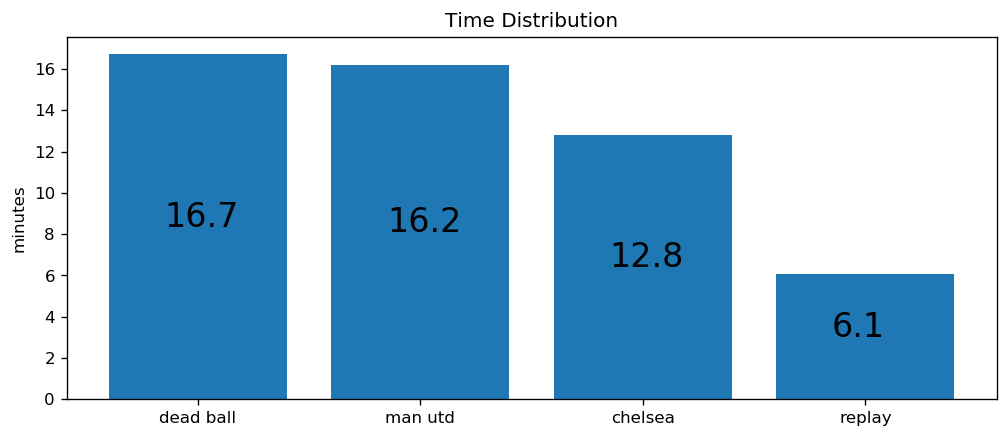

In [12]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
plt.bar(minutes_per_label['human_label'], minutes_per_label['minutes'])

for i, v in enumerate(minutes_per_label['minutes']):
    plt.text(i - 0.15, v / 2, str(round(v, 1)), size = 20)

plt.ylabel('minutes')    
plt.title('Time Distribution')
plt.show()

### Possession Distribution over time

In [13]:
pivot_labels = pd.pivot_table(labels_, values='minutes', index=['frame'],
                              columns=['human_label'], aggfunc=np.sum, fill_value=0)

pivot_labels['frame'] = pivot_labels.index
pivot_labels = pivot_labels.reset_index(drop=True).rename_axis(None, axis=1)

cum_pivot_labels = pivot_labels.copy()
cum_pivot_labels['chelsea'] = np.cumsum(pivot_labels['chelsea'])
cum_pivot_labels['man utd'] = np.cumsum(pivot_labels['man utd'])
cum_pivot_labels['dead ball'] = np.cumsum(pivot_labels['dead ball'])
cum_pivot_labels['replay'] = np.cumsum(pivot_labels['replay'])

cum_pivot_labels = cum_pivot_labels[['frame', 'chelsea', 'man utd', 'dead ball', 'replay']]

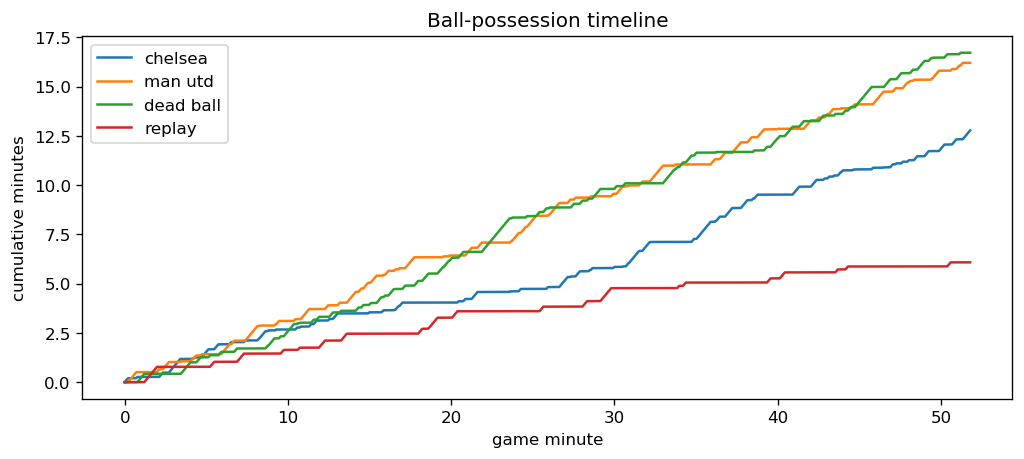

In [14]:
fig, axes = plt.subplots(figsize=(10,4), dpi=120)
minutes = cum_pivot_labels['frame'] / (10 * 3 * 60)
df_minutes_labels = cum_pivot_labels.drop('frame', axis = 1)
for label in list(df_minutes_labels):
    plt.plot(minutes, df_minutes_labels[label], label = label)

plt.xlabel('game minute')
plt.ylabel('cumulative minutes')
plt.legend()
plt.title('Ball-possession timeline')
plt.show()

### Why there are several jumps in the series? 

In [15]:
time_unit = 1 / FRAMES_PER_SECOND
current_label = labels_['human_label'][0]
length = 0
sequences = []

for label in labels_['human_label'][:-1]:
    if label == current_label:
        length += time_unit
    else:
        sequences.append((current_label, length))
        current_label = label
        length = time_unit
sequences.append((current_label, length+time_unit)) 
sequences = pd.DataFrame(sequences)
sequences.columns = ['label', 'seconds']

top_sequences = sequences.sort_values('seconds', ascending=False).head(20)

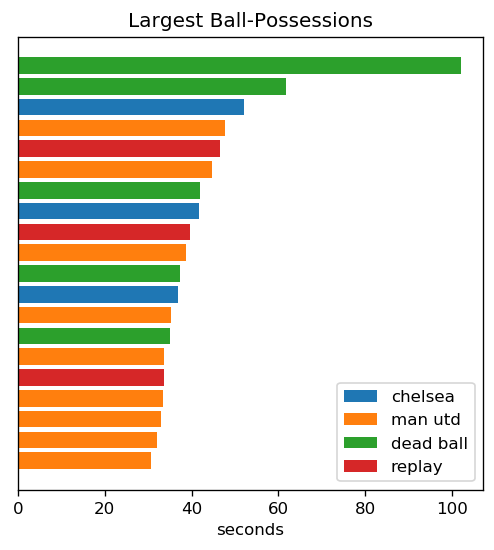

In [16]:
fig, axes = plt.subplots(figsize=(5,5), dpi=120)

y_values = np.arange(top_sequences.shape[0],0,-1)
labels_ = ['chelsea', 'man utd', 'dead ball', 'replay']

for label in labels_:
    mask = top_sequences['label'] == label
    plt.barh(y_values[mask], top_sequences['seconds'][mask], label = label)

plt.legend()
plt.yticks([])
plt.xlabel('seconds')
plt.title('Largest Ball-Possessions')
plt.show()

## Data Wrangling

In [17]:
def frame_num_to_image_path(frame):
    return("../../Pranay/SoccerLearning-master/ExtractFrames/match_frames/frame%s.jpg" % frame)

labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

frame  label                                           img_path
0         0      1  ../../Pranay/SoccerLearning-master/ExtractFram...
1        10      1  ../../Pranay/SoccerLearning-master/ExtractFram...
2        20      1  ../../Pranay/SoccerLearning-master/ExtractFram...
3        30      1  ../../Pranay/SoccerLearning-master/ExtractFram...
4        40      1  ../../Pranay/SoccerLearning-master/ExtractFram...
...     ...    ...                                                ...
9319  93190      1  ../../Pranay/SoccerLearning-master/ExtractFram...
9320  93200      1  ../../Pranay/SoccerLearning-master/ExtractFram...
9321  93210      1  ../../Pranay/SoccerLearning-master/ExtractFram...
9322  93220      1  ../../Pranay/SoccerLearning-master/ExtractFram...
9323  93230      1  ../../Pranay/SoccerLearning-master/ExtractFram...

[9324 rows x 3 columns]

Tag: man utd


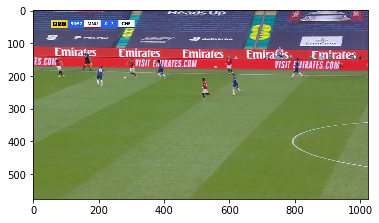

Tag: man utd


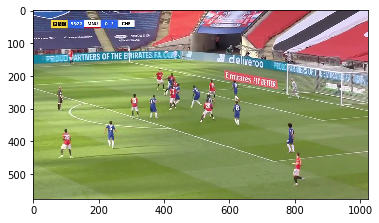

Tag: replay


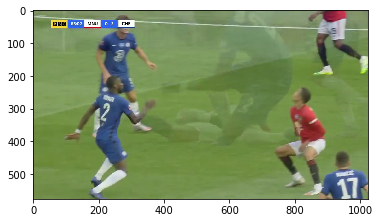

Tag: chelsea


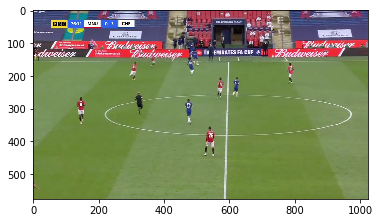

Tag: man utd


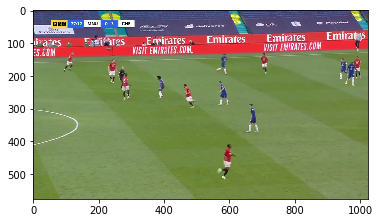

Tag: dead ball


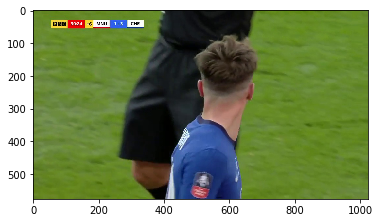

In [18]:
random.seed(220)
for index, row in labels_df.iterrows():
    frame = row['frame']
    label = row['label']
    img_path = row['img_path']

    # Verify the image is in the folder
    assert os.path.exists(img_path)   

  # Shows some images
    if random.random() < 0.001:
        image_ = mpimg.imread(img_path)
        print('Tag: %s' % get_human_label(label))
        plt.gca().clear()
        plt.imshow(image_)
        plt.show()      

## Split train, validation and test 

training using only the first 20 minutes, predicting the next 25.

In [20]:
len(labels_df)

9324

In [21]:
FRAME_THRESHOLD = 3680 #First 20 minutes
train_val = labels_df[:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:-12] #ensuring batch size of 32
train, val = train_test_split(train_val, test_size=0.2, random_state=2020)

## Save activations from Inception V3 for all the images

In [22]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [23]:
# extract activations using the model above. 
def image_to_activations(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    activations = tf.keras.applications.inception_v3.preprocess_input(img)
    return activations, image_path

In [24]:
image_path_set = set(labels_df['img_path'])

print("Images to preprocess", len(image_path_set))

Images to preprocess 9324


In [ ]:
# extracting activations for each image

# Create a dataset to load each image off disk, and extract activations
activation_dataset = tf.data.Dataset.from_tensor_slices(list(image_path_set))
activation_dataset = activation_dataset.map(
  image_to_activations, 
  num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(32)

# Saving all activations in NumPy format
for img_batch, path_batch in activation_dataset:
  batch_features = image_features_extract_model(img_batch)
  for bf, p in zip(batch_features, path_batch):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())  

## Convert data to an appropiate batch format to train the model

In [25]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [26]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

In [27]:
def load_np(img_path, label):
    activations = np.load(img_path.decode('utf-8')+'.npy')
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function(
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [28]:
train_ds = create_dataset(images_train, labels_train, shuff = False)
val_ds = create_dataset(images_val, labels_val, shuff = False)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [29]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

print(activations_batch, 
      labels_batch, 
      paths_batch)

(32, 8, 8, 2048) (32,) (32,)
tf.Tensor(
[[[[1.0583719  0.         0.         ... 0.         0.
    0.        ]
   [1.4001902  0.         0.09200341 ... 0.         0.
    0.        ]
   [0.5935329  0.         0.6458707  ... 0.         0.
    0.        ]
   ...
   [0.437566   0.         0.270491   ... 0.         0.
    0.        ]
   [0.         0.5906106  0.51388144 ... 0.         0.
    0.        ]
   [0.         0.         0.18827808 ... 0.         0.25548446
    0.        ]]

  [[1.0389054  0.1816364  0.         ... 0.         0.
    0.        ]
   [1.1543432  0.         0.         ... 0.         0.
    0.        ]
   [1.373615   0.         0.         ... 0.         0.
    0.        ]
   ...
   [0.4075115  0.11160316 0.         ... 0.         0.
    0.        ]
   [0.56843555 0.         0.         ... 0.         0.
    0.        ]
   [0.         0.         0.         ... 0.         0.29577634
    0.        ]]

  [[0.         0.04333068 0.         ... 0.         0.
    0.        ]
   

## CNN Approach

### Design the CNN

In [30]:
image_input = Input(shape=(8, 8, 2048)) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(encoded_image)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

# Your final model
model = Model(inputs=image_input, outputs=output)

In [31]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 8, 8, 2048)]      0         
_________________________________________________________________
sequential (Sequential)      (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 135,556
Trainable params: 135,556
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train on a single batch to verify everything is working

In [33]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [34]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [35]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

Loss: 0.001262
Accuracy: 1.000000


In [36]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

[1.9348958e-05 9.9980921e-01 1.0108543e-05 1.6139832e-04] 1.0
[1.8501976e-03 4.7627496e-04 9.9767238e-01 1.1627263e-06] 2.0
[5.9758673e-07 9.9855310e-01 7.4229058e-04 7.0392789e-04] 1.0
[5.6613114e-04 1.1945588e-04 2.9735873e-04 9.9901700e-01] 3.0
[4.4481189e-04 5.2308016e-03 9.9425513e-01 6.9198948e-05] 2.0
[1.2271660e-05 2.7517378e-04 9.9969101e-01 2.1623420e-05] 2.0
[1.4665202e-04 3.5369626e-04 4.0243917e-06 9.9949563e-01] 3.0
[1.5795858e-05 7.9672818e-06 2.4721348e-06 9.9997377e-01] 3.0
[9.9884218e-01 1.4130836e-05 1.0985864e-03 4.5145982e-05] 0.0
[3.8128428e-04 5.4463424e-05 9.9956197e-01 2.2672241e-06] 2.0
[9.9982578e-01 1.5911548e-05 2.3545736e-06 1.5602593e-04] 0.0
[1.3318439e-05 8.2341791e-04 2.8893633e-06 9.9916041e-01] 3.0
[9.9989676e-01 2.7687208e-06 1.3297936e-05 8.7091270e-05] 0.0
[1.9441952e-04 6.5586343e-04 9.9909532e-01 5.4429795e-05] 2.0
[9.9977857e-01 3.6379282e-05 2.5240683e-05 1.5983089e-04] 0.0
[1.2251626e-04 3.4353882e-04 9.9944049e-01 9.3461262e-05] 2.0
[5.94006

### Manage checkpoints in case we want to fit the model for a long time

In [37]:
checkpoint_dir = "soccer_checkpoints/CNN_"
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

Checkpoints directory is soccer_checkpoints/CNN_
Checkpoints folder already exists


In [38]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from soccer_checkpoints/CNN_\cp-00000049.ckpt


### Fit the model

In [39]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [40]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [41]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

Epoch 0, Loss: 0.01, Accuracy: 99.49, Val Loss 0.43, Val Accuracy 90.90, Time: 25.8 secs
Saving weights
Epoch 1, Loss: 0.03, Accuracy: 98.85, Val Loss 0.34, Val Accuracy 92.93, Time: 9.2 secs
Saving weights
Epoch 2, Loss: 0.01, Accuracy: 99.86, Val Loss 0.37, Val Accuracy 92.39, Time: 8.2 secs
Saving weights
Epoch 3, Loss: 0.00, Accuracy: 100.00, Val Loss 0.35, Val Accuracy 93.34, Time: 8.4 secs
Saving weights
Epoch 4, Loss: 0.00, Accuracy: 100.00, Val Loss 0.34, Val Accuracy 93.75, Time: 8.1 secs
Saving weights
Epoch 5, Loss: 0.00, Accuracy: 100.00, Val Loss 0.33, Val Accuracy 93.89, Time: 8.3 secs
Saving weights
Epoch 6, Loss: 0.00, Accuracy: 100.00, Val Loss 0.33, Val Accuracy 93.89, Time: 8.1 secs
Saving weights
Epoch 7, Loss: 0.00, Accuracy: 100.00, Val Loss 0.33, Val Accuracy 93.75, Time: 8.3 secs
Saving weights
Epoch 8, Loss: 0.00, Accuracy: 100.00, Val Loss 0.33, Val Accuracy 93.75, Time: 8.2 secs
Saving weights
Epoch 9, Loss: 0.00, Accuracy: 100.00, Val Loss 0.33, Val Accuracy

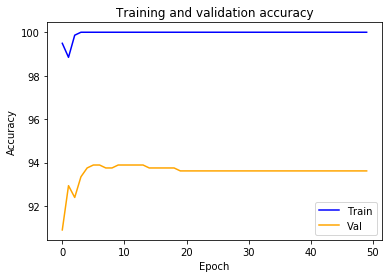

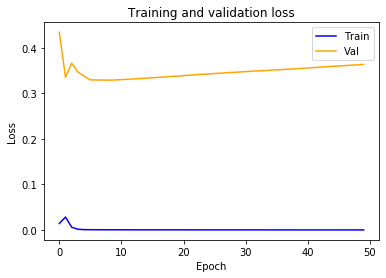

In [42]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [43]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from soccer_checkpoints/CNN_\cp-00000049.ckpt


True label: chelsea
Predicted label: man utd
Confidence of the prediction: 0.5912655


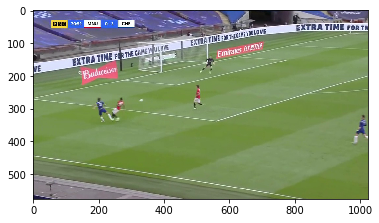

True label: man utd
Predicted label: man utd
Confidence of the prediction: 1.0


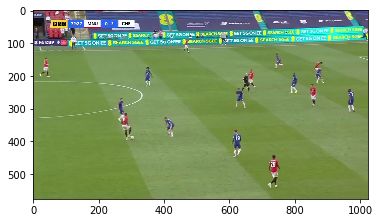

True label: chelsea
Predicted label: dead ball
Confidence of the prediction: 0.970144


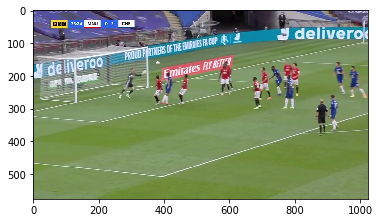

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 1.0


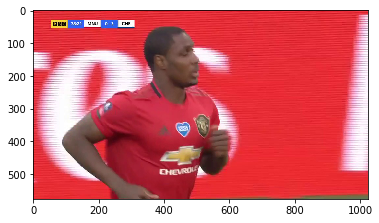

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.9602552


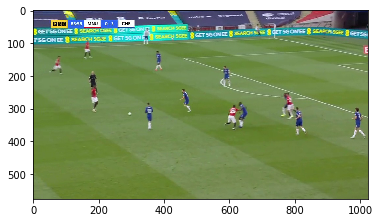

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 0.9999999


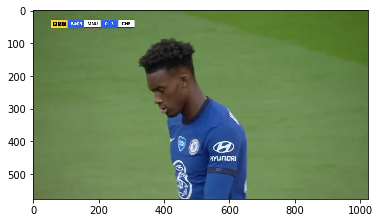

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 0.99999094


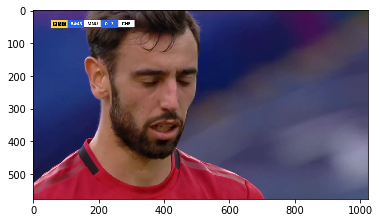

True label: man utd
Predicted label: man utd
Confidence of the prediction: 1.0


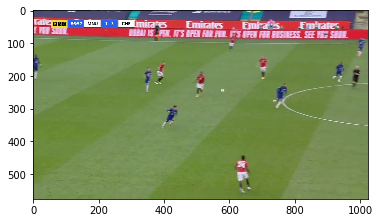

True label: chelsea
Predicted label: chelsea
Confidence of the prediction: 0.77706057


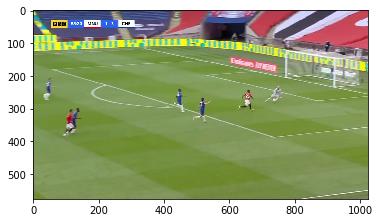

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.9999995


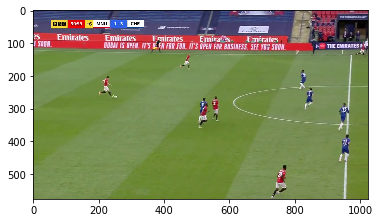

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.9999906


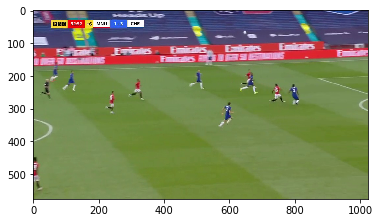

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 1.0


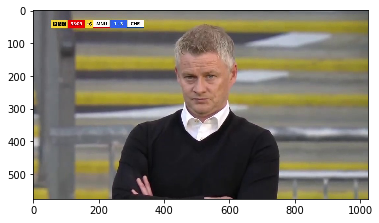

In [44]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [45]:
print('The test accuracy is: %f' % np.mean(acc_list))

The test accuracy is: 0.628906


In [46]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [47]:
predictions_cnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_cnn

img_path  frame  label  \
0     ../../Pranay/SoccerLearning-master/ExtractFram...  36800      1   
1     ../../Pranay/SoccerLearning-master/ExtractFram...  36810      0   
2     ../../Pranay/SoccerLearning-master/ExtractFram...  36820      0   
3     ../../Pranay/SoccerLearning-master/ExtractFram...  36830      0   
4     ../../Pranay/SoccerLearning-master/ExtractFram...  36840      0   
...                                                 ...    ...    ...   
5627  ../../Pranay/SoccerLearning-master/ExtractFram...  93070      1   
5628  ../../Pranay/SoccerLearning-master/ExtractFram...  93080      1   
5629  ../../Pranay/SoccerLearning-master/ExtractFram...  93090      1   
5630  ../../Pranay/SoccerLearning-master/ExtractFram...  93100      1   
5631  ../../Pranay/SoccerLearning-master/ExtractFram...  93110      1   

      pred_label  confidence  
0              1    0.951630  
1              1    0.999937  
2              1    0.948416  
3              1    0.537709  
4              2    0.999799  
...          ...         ...  
5627           1    0.841098  
5628           1    0.999976  
5629           1    0.999994  
5630           2    0.986193  
5631           1    0.999421  

[5632 rows x 5 columns]

In [48]:
pred_labels = pd.Series(map(get_human_label, predictions_cnn['pred_label']))
labels = pd.Series(map(get_human_label, predictions_cnn['label']))

In [49]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

pred        chelsea  dead ball   man utd    replay       All
label                                                       
chelsea    0.104048   0.023615  0.142045  0.005682  0.275391
dead ball  0.020952   0.231357  0.045810  0.034446  0.332564
man utd    0.070312   0.017045  0.218395  0.006925  0.312678
replay     0.001065   0.003018  0.000178  0.075107  0.079368
All        0.196378   0.275036  0.406428  0.122159  1.000000

#### Recall

In [50]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

pred        chelsea  dead ball   man utd    replay
label                                             
chelsea    0.377821   0.085751  0.515796  0.020632
dead ball  0.063001   0.695675  0.137747  0.103577
man utd    0.224872   0.054514  0.698467  0.022147
replay     0.013423   0.038031  0.002237  0.946309

#### Precision

In [51]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

pred        chelsea  dead ball   man utd    replay
label                                             
chelsea    0.529837   0.085862  0.349498  0.046512
dead ball  0.106691   0.841188  0.112713  0.281977
man utd    0.358047   0.061975  0.537353  0.056686
replay     0.005425   0.010975  0.000437  0.614826

## CNN + RNN Approach

### Design the CNN + RNN

In [52]:
from tensorflow.keras.layers import Dense, Embedding, Flatten, Input, LSTM, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, GRU, Concatenate
from tensorflow.keras.models import Model, Sequential

image_input = Input(shape=(8, 8, 2048), batch_size=32) 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(GlobalAveragePooling2D())
encoded_image = vision_model(image_input)
encoded_image_drop = Dropout(0.5)(encoded_image)

# Adding Gated Recurred Units
encoded_image_reshape = Reshape((1, 2048))(encoded_image_drop)
gru_1 = GRU(32, stateful=True, dropout=0.3, recurrent_dropout=0.3)(encoded_image_reshape)
#gru_2 = GRU(64, stateful=True, dropout=0.3, recurrent_dropout=0.3)(gru_1)

# Combining both CNN and RNN outputs
x = Concatenate()([gru_1, encoded_image_drop])

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(x)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

model = Model(inputs=image_input, outputs=output)

In [53]:
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(32, 8, 8, 2048)]   0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (32, 2048)           0           input_3[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (32, 2048)           0           sequential_1[0][0]               
__________________________________________________________________________________________________
reshape (Reshape)               (32, 1, 2048)        0           dropout[0][0]                    
_______________________________________________________________________________________

In [54]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Train on a single batch to verify everything is working

In [55]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [56]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [57]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

Loss: 0.006140
Accuracy: 1.000000


In [58]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

[8.9537980e-06 9.9993551e-01 2.4743482e-05 3.0774147e-05] 1.0
[2.8290457e-04 1.0667009e-03 9.9865025e-01 1.3289910e-07] 2.0
[2.3627871e-07 9.9928147e-01 6.9701631e-04 2.1375665e-05] 1.0
[9.8033145e-04 1.4974487e-04 1.0703085e-03 9.9779958e-01] 3.0
[1.3448492e-04 1.4125156e-02 9.8567653e-01 6.3748783e-05] 2.0
[8.2705986e-07 7.3970394e-04 9.9925405e-01 5.3836939e-06] 2.0
[4.1301048e-04 1.4517567e-04 1.7439190e-05 9.9942446e-01] 3.0
[2.6570744e-06 2.8278153e-06 5.7961472e-07 9.9999392e-01] 3.0
[9.991881e-01 1.588803e-05 6.981027e-04 9.794219e-05] 0.0
[2.622752e-05 6.364544e-05 9.999094e-01 7.263569e-07] 2.0
[9.9989176e-01 3.0705611e-05 1.4314852e-06 7.6082615e-05] 0.0
[7.3616793e-05 4.2578042e-04 1.5084015e-05 9.9948549e-01] 3.0
[9.9984694e-01 3.1159141e-06 2.1109072e-05 1.2887908e-04] 0.0
[1.5018426e-05 7.0449617e-04 9.9926299e-01 1.7531696e-05] 2.0
[9.9988842e-01 1.0665108e-05 6.8504892e-06 9.4194540e-05] 0.0
[5.2849500e-06 3.4575368e-04 9.9963748e-01 1.1410530e-05] 2.0
[5.8645754e-05 9

### Manage checkpoints in case we want to fit the model for a long time

In [59]:
checkpoint_dir = "soccer_checkpoints/RNN"
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

Checkpoints directory is soccer_checkpoints/RNN
Checkpoints folder already exists


In [60]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

Loading weights from soccer_checkpoints/RNN\cp-00000022.ckpt


### Fit the model

In [61]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [62]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [63]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50 

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

Epoch 0, Loss: 0.33, Accuracy: 86.21, Val Loss 0.35, Val Accuracy 86.41, Time: 89.2 secs
Saving weights
Epoch 1, Loss: 0.32, Accuracy: 87.40, Val Loss 0.38, Val Accuracy 85.05, Time: 8.8 secs
Saving weights
Epoch 2, Loss: 0.32, Accuracy: 87.09, Val Loss 0.33, Val Accuracy 86.28, Time: 8.8 secs
Saving weights
Epoch 3, Loss: 0.32, Accuracy: 86.99, Val Loss 0.35, Val Accuracy 85.19, Time: 9.8 secs
Saving weights
Epoch 4, Loss: 0.30, Accuracy: 87.81, Val Loss 0.34, Val Accuracy 87.77, Time: 8.9 secs
Saving weights
Epoch 5, Loss: 0.29, Accuracy: 87.67, Val Loss 0.33, Val Accuracy 86.82, Time: 9.3 secs
Saving weights
Epoch 6, Loss: 0.31, Accuracy: 87.16, Val Loss 0.32, Val Accuracy 87.91, Time: 9.4 secs
Saving weights
Epoch 7, Loss: 0.29, Accuracy: 88.62, Val Loss 0.31, Val Accuracy 88.59, Time: 9.0 secs
Saving weights
Epoch 8, Loss: 0.30, Accuracy: 87.67, Val Loss 0.33, Val Accuracy 87.36, Time: 9.5 secs
Saving weights
Epoch 9, Loss: 0.27, Accuracy: 88.89, Val Loss 0.30, Val Accuracy 87.50,

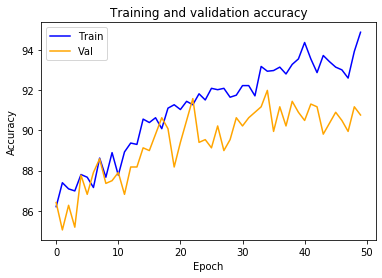

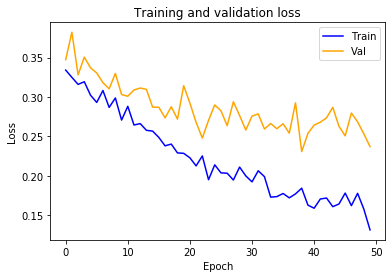

In [64]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [65]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

loaded weights from soccer_checkpoints/RNN\cp-00000049.ckpt


True label: chelsea
Predicted label: chelsea
Confidence of the prediction: 0.74912345


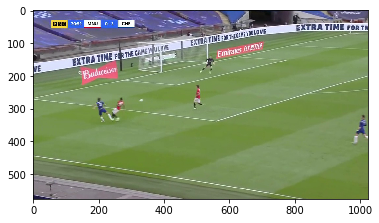

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.99286604


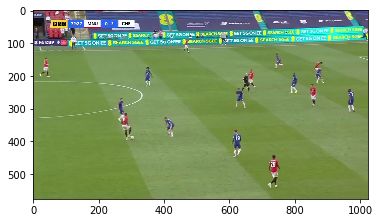

True label: chelsea
Predicted label: chelsea
Confidence of the prediction: 0.72550046


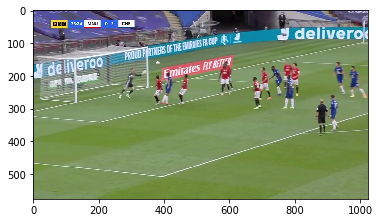

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 0.99999917


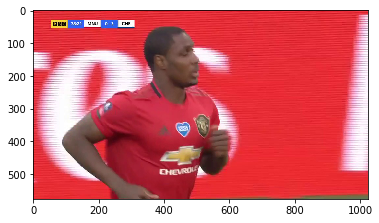

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.55809456


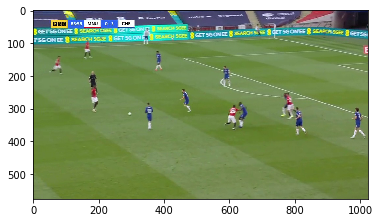

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 0.9999871


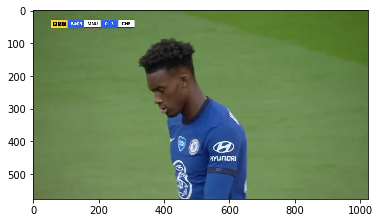

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 0.99985003


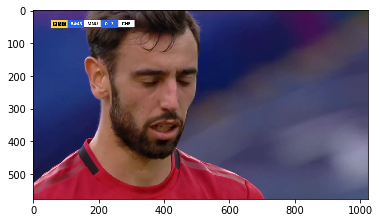

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.9855004


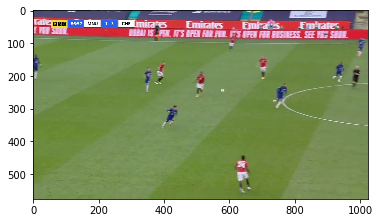

True label: chelsea
Predicted label: man utd
Confidence of the prediction: 0.98800755


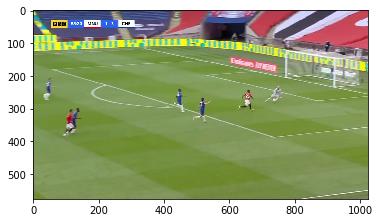

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.9818811


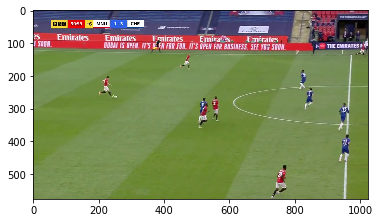

True label: man utd
Predicted label: man utd
Confidence of the prediction: 0.9967969


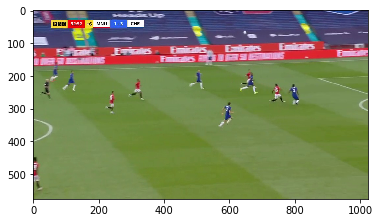

True label: dead ball
Predicted label: dead ball
Confidence of the prediction: 1.0


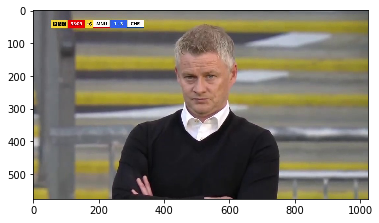

In [66]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [67]:
print('The test accuracy is: %f' % np.mean(acc_list))

The test accuracy is: 0.631214


In [68]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [69]:
predictions_rnn = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_rnn

img_path  frame  label  \
0     ../../Pranay/SoccerLearning-master/ExtractFram...  36800      1   
1     ../../Pranay/SoccerLearning-master/ExtractFram...  36810      0   
2     ../../Pranay/SoccerLearning-master/ExtractFram...  36820      0   
3     ../../Pranay/SoccerLearning-master/ExtractFram...  36830      0   
4     ../../Pranay/SoccerLearning-master/ExtractFram...  36840      0   
...                                                 ...    ...    ...   
5627  ../../Pranay/SoccerLearning-master/ExtractFram...  93070      1   
5628  ../../Pranay/SoccerLearning-master/ExtractFram...  93080      1   
5629  ../../Pranay/SoccerLearning-master/ExtractFram...  93090      1   
5630  ../../Pranay/SoccerLearning-master/ExtractFram...  93100      1   
5631  ../../Pranay/SoccerLearning-master/ExtractFram...  93110      1   

      pred_label  confidence  
0              2    0.654810  
1              1    0.501469  
2              1    0.756941  
3              2    0.878139  
4              2    0.787340  
...          ...         ...  
5627           2    0.815971  
5628           2    0.523438  
5629           2    0.609845  
5630           2    0.948142  
5631           2    0.917372  

[5632 rows x 5 columns]

In [70]:
pred_labels = pd.Series(map(get_human_label, predictions_rnn['pred_label']))
labels = pd.Series(map(get_human_label, predictions_rnn['label']))

In [71]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

pred        chelsea  dead ball   man utd    replay       All
label                                                       
chelsea    0.094283   0.015447  0.160689  0.004972  0.275391
dead ball  0.026456   0.243963  0.044567  0.017578  0.332564
man utd    0.078125   0.009943  0.220703  0.003906  0.312678
replay     0.001420   0.004439  0.001065  0.072443  0.079368
All        0.200284   0.273793  0.427024  0.098899  1.000000

#### Recall

In [72]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

pred        chelsea  dead ball   man utd    replay
label                                             
chelsea    0.342360   0.056093  0.583495  0.018053
dead ball  0.079552   0.733582  0.134010  0.052856
man utd    0.249858   0.031800  0.705849  0.012493
replay     0.017897   0.055928  0.013423  0.912752

#### Precision

In [73]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

pred        chelsea  dead ball   man utd    replay
label                                             
chelsea    0.470745   0.056420  0.376299  0.050269
dead ball  0.132092   0.891051  0.104366  0.177738
man utd    0.390071   0.036316  0.516840  0.039497
replay     0.007092   0.016213  0.002495  0.732496

## Scene-based Approach

Scene-based approach means that we will be utilizing "scenes" instead of singular frames. Scenes are build up over 6 sequential frames (2 seconds of real-time) where the game state is constant over all 6 frames. No two scenes can share any frames.

### Pipeline changes due to scene vs image loading

In [ ]:
labels_path = os.path.join(drive_root, "labels_scene.csv")
labels_df = pd.read_csv(labels_path)
labels_ = labels_df.copy()

labels_['human_label'] = list(map(get_human_label, labels_['label']))
labels_['minutes'] = 1 / (60 * 3)
labels_df['img_path'] = list(map(frame_num_to_image_path, labels_df['frame']))
labels_df

Train/test split on only scenes





In [ ]:
labels_df = labels_df.sample(frac=1)
FRAME_THRESHOLD = int(labels_df.shape[0]*2/3)
train_val = labels_df[:FRAME_THRESHOLD]
test = labels_df[FRAME_THRESHOLD:]
train, val = train_test_split(train_val, test_size=0.2, random_state=2019)

#### Convert data to an appropiate batch format to train the model

In [ ]:
labels_train = list([1.0 * label for label in train['label']]) 
images_train = list(train['img_path']) 

labels_val = list([1.0 * label for label in val['label']]) 
images_val = list(val['img_path']) 

labels_test = list([1.0 * label for label in test['label']]) 
images_test = list(test['img_path']) 

In [ ]:
BATCH_SIZE = 32
BUFFER_SIZE = 1000

#modify to return past 2 seconds of activations instead of just 1 frame
def load_np(img_path, label):
    img_number = int(img_path.decode('utf-8').split('/')[3][5:-4])
    activation_0 = np.load(img_path.decode('utf-8')+'.npy')
    activation_1 = np.load(img_path.decode('utf-8').replace(
        str(img_number+10), str(img_number)) + '.npy')
    activation_2 = np.load(img_path.decode('utf-8').replace(
        str(img_number+20), str(img_number)) + '.npy')
    activation_3 = np.load(img_path.decode('utf-8').replace(
        str(img_number+30), str(img_number)) + '.npy')
    activation_4 = np.load(img_path.decode('utf-8').replace(
        str(img_number+40), str(img_number)) + '.npy')
    activation_5 = np.load(img_path.decode('utf-8').replace(
        str(img_number+50), str(img_number)) + '.npy')
    activations = np.dstack((activation_0, activation_1, activation_2, 
                            activation_3, activation_4, activation_5))
    return activations, label, img_path

def create_dataset(images, labels, shuff = True):
    dataset = tf.data.Dataset.from_tensor_slices((images, 
                                                  labels))
    # Load the cached activations off disk
    dataset = dataset.map(lambda x, y: tf.numpy_function(
        load_np, [x, y], [tf.float32, tf.float32, tf.string]),
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    # Shuffle and batch
    if shuff:
        dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
    else:
        dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
train_ds = create_dataset(images_train, labels_train)
val_ds = create_dataset(images_val, labels_val)
test_ds = create_dataset(images_test, labels_test, shuff = False)

In [ ]:
my_iterator = iter(train_ds)
activations_batch, labels_batch, paths_batch = next(my_iterator)

print(activations_batch.shape, 
      labels_batch.shape, 
      paths_batch.shape)

### Design the model

In [ ]:
image_input = Input(shape=(8, 8, 2048*6)) #must multiply input by 6 in scene 
vision_model = Sequential()
# Used to reduce the number of parameters (rather using a dense layer here).
vision_model.add(tf.keras.layers.GlobalAveragePooling2D())
encoded_image = vision_model(image_input) 

# Add dense layers between the activations and the output
dense = Dense(64, activation='relu')(encoded_image)
dense = Dense(64, activation='relu')(dense)

# Next, add a binary classifier on top
output = Dense(4, activation='softmax')(dense)

# Your final model
model = Model(inputs=image_input, outputs=output)

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

### Train on a single batch to verify everything is working

In [ ]:
# Retrieve a batch of data from your train dataset
activations_batch, labels_batch, paths_batch = next(iter(train_ds))

In [ ]:
for i in range(100):
  metrics = model.train_on_batch(activations_batch, labels_batch)

In [ ]:
print('Loss: %f' % metrics[0])
print('Accuracy: %f' % metrics[1])

In [ ]:
for prediction, label in zip(model.predict(x=activations_batch), labels_batch):
  print(prediction, label.numpy())

### Manage checkpoints in case we want to fit the model for a long time

In [ ]:
checkpoint_dir = os.path.join(drive_root, "soccer_checkpoints/SCENE")
checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:08d}.ckpt")

print("Checkpoints directory is", checkpoint_dir)
if os.path.exists(checkpoint_dir):
    print("Checkpoints folder already exists")
else:
    print("Creating a checkpoints directory")
    os.makedirs(checkpoint_dir)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
if latest != None:
  print("Loading weights from", latest)
  model.load_weights(latest)
else:
  print("Checkpoint not found. Starting from scratch")

### Fit the model

In [ ]:
# Utilities to help us record metrics.
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [ ]:
def evaluate(max_steps=None):
  steps = 0
  for activation_batch, label_batch, path_batch in val_ds:
    if max_steps != None and steps == max_steps:
      break
    predictions = model.predict(x=activation_batch)
    steps += 1 
    # Record metrics after each batch
    val_loss(label_batch, predictions)
    val_accuracy(label_batch, predictions)

In [ ]:
# Used to track loss and accuracy as we go
train_loss_history, train_acc_history = [], []
val_loss_history, val_acc_history = [], []

epochs = 50

# Training loop
for epoch in range(epochs):

    start = time.time()

    # Train for one epoch
    for activation_batch, label_batch, path_batch in train_ds:
        result = model.train_on_batch(x=activation_batch, y=label_batch)

        # Record metrics after each batch
        train_loss(result[0])
        train_accuracy(result[1])

    # Evaluate for a few steps
    evaluate(max_steps=100)

    # Print progress
    template = 'Epoch {}, Loss: {:.2f}, Accuracy: {:.2f}, Val Loss {:.2f}, Val Accuracy {:.2f}, Time: {:.1f} secs'
    print(template.format(epoch,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          val_loss.result(),
                          val_accuracy.result() * 100,
                          time.time() - start))
    
    # Record history
    train_loss_history.append(train_loss.result())
    train_acc_history.append(train_accuracy.result() * 100)
    val_loss_history.append(val_loss.result())
    val_acc_history.append(val_accuracy.result() * 100)

    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()

    # Save a checkpoint after each epoch
    print("Saving weights")
    model.save_weights(checkpoint_path.format(epoch=epoch))

In [ ]:
def plot(loss, acc, val_loss, val_acc):
  
  # Get the number of epochs
  epochs = range(len(acc))

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(train_loss_history, train_acc_history, val_loss_history, val_acc_history)

#### Predict on the test dataset and save results

In [ ]:
# Restore the latest checkpoint
latest = tf.train.latest_checkpoint(checkpoint_dir)
assert latest != None
model.load_weights(latest)
print("loaded weights from", latest)

In [ ]:
random.seed(2021)
acc_list = list()
predictions_list = list()
confidences_list = list()
paths_list = list()

for activation_batch, label_batch, path_batch in test_ds:
    score, acc = model.evaluate(activation_batch, label_batch, verbose=0)
    acc_list.append(acc)
    
    preds = model.predict(activation_batch)
    predictions_batch = list(np.argmax(preds, axis = 1))
    confidences_batch = list(np.max(preds, axis = 1))
    paths_batch = list(path_batch.numpy())
    paths_batch = [path.decode('utf-8') for path in paths_batch]
    labels_batch = list(label_batch.numpy())

    predictions_list = predictions_list + predictions_batch
    confidences_list = confidences_list + confidences_batch
    paths_list = paths_list + paths_batch

    for i in range(len(labels_batch)):
        if random.random() < 0.002:
            print('True label: %s' % get_human_label(labels_batch[i]))
            print('Predicted label: %s' % get_human_label(predictions_batch[i]))
            print('Confidence of the prediction: %s' % confidences_batch[i])
            image_ = mpimg.imread(paths_batch[i])
            plt.gca().clear()
            plt.imshow(image_)
            plt.show()     

In [ ]:
print('The test accuracy is: %f' % np.mean(acc_list))

In [ ]:
preds_df = pd.DataFrame({'img_path': paths_list,
                         'pred_label': predictions_list,
                         'confidence': confidences_list      
})

In [ ]:
predictions_scene = test.set_index('img_path').join(preds_df.set_index('img_path')).reset_index()
predictions_scene

In [ ]:
pred_labels = pd.Series(map(get_human_label, predictions_scene['pred_label']))
labels = pd.Series(map(get_human_label, predictions_scene['label']))

In [ ]:
pd.crosstab(labels, pred_labels,
            rownames = ['label'], colnames = ['pred'],
            normalize = 'all', margins = True)

#### Recall

In [ ]:
recall = pd.crosstab(labels, pred_labels,
                     rownames = ['label'], colnames = ['pred'],
                     normalize = 'index')
recall

#### Precision

In [ ]:
precision = pd.crosstab(labels, pred_labels,
                        rownames = ['label'], colnames = ['pred'],
                        normalize = 'columns')
precision

## NOTEBOOK COMPLETE